In [1]:
import argparse
import gym
from typing import List
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from matplotlib import pyplot as plt


In [2]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Helper Utilities 

In [3]:
# Types for the Lesson
State = np.array
Action = int
Reward = float
Loss = float

In [120]:
GAMMA = 0.999

## Vanilla Policy Gradients with REINFORCE

### Define a Policy 

In Policy Gradient methods, we optimize a policy directly. This is a more natural version of the RL Problem. 

In [128]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, state: State) -> torch.Tensor:
        state = F.relu(self.affine1(state))
        action_scores = self.affine2(state)
        return F.softmax(action_scores, dim=1)

### Select Action from Samples 

In [129]:
def select_action(state: State) -> Action:
    """Given State use the instantiated policy to take the best action
    """
    pass 


### Calculate Discounted Rewards and Calculate Policy Loss Function 

In [130]:
def calculate_discounted_rewards(
    rewards: List[Reward],
    discount: float=GAMMA
) -> torch.tensor:
    """Calculate Discounted Sum of Rewards 
    """
    pass 

In [131]:
def calculate_policy_loss(
    log_probs: List[float],
    rewards: torch.tensor
) -> List[Loss]:
    """Calculate the Policy Loss 
    """
    pass 

**Instantiate the Policy**

In [132]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

**Training Loop**

In [133]:
running_rewards = []
last_number_of_episodes = 100


for episode in count(1):
    state = env.reset()
    length_of_episode = 0
    done = False
    
    for t in range(10000):  # Don't infinite loop while learning
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        policy.rewards.append(reward)
        if done:
            break

    
    # Caculate Discounted Rewards 
    rewards = calculate_discounted_rewards(policy.rewards[::-1])
    rewards = torch.tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)
    
    # Caculate the Policy Loss 
    policy_loss = calculate_policy_loss(policy.saved_log_probs, rewards)
    
    
    # Do the Backwards Pass to Update the Policy Gradient 
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]
    
    average_reward = np.mean(running_rewards[-last_number_of_episodes:])
    if episode % 10 == 0:
        print('Episode {}\tLast Reward: {:5d}\tAverage Reward: {:.2f}'.format(
            episode, t, average_reward))
    if average_reward > env.spec.reward_threshold:
        print("Solved! Average reward is now {} and "
              "the last episode runs to {} time steps!".format(average_reward, t))
        break
    running_rewards.append(t)

/Users/vora-family/Desktop/rl-talk-kdd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vora-family/Desktop/rl-talk-kdd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 10	Last Reward:    24	Average Reward: 33.11
Episode 20	Last Reward:    65	Average Reward: 47.68
Episode 30	Last Reward:   130	Average Reward: 66.10
Episode 40	Last Reward:    34	Average Reward: 70.90
Episode 50	Last Reward:    20	Average Reward: 62.65
Episode 60	Last Reward:    53	Average Reward: 56.85
Episode 70	Last Reward:    81	Average Reward: 57.20
Episode 80	Last Reward:    43	Average Reward: 62.05
Episode 90	Last Reward:    45	Average Reward: 60.31
Episode 100	Last Reward:    36	Average Reward: 58.88
Episode 110	Last Reward:    38	Average Reward: 60.68
Episode 120	Last Reward:    69	Average Reward: 62.60
Episode 130	Last Reward:    52	Average Reward: 60.66
Episode 140	Last Reward:    57	Average Reward: 58.06
Episode 150	Last Reward:   110	Average Reward: 64.55
Episode 160	Last Reward:   171	Average Reward: 76.48
Episode 170	Last Reward:   168	Average Reward: 88.67
Episode 180	Last Reward:   113	Average Reward: 94.74
Episode 190	Last Reward:   106	Average Reward: 100.29
E

Episode 1540	Last Reward:   199	Average Reward: 179.98
Episode 1550	Last Reward:   199	Average Reward: 183.82
Episode 1560	Last Reward:   199	Average Reward: 187.23
Episode 1570	Last Reward:   199	Average Reward: 191.64
Episode 1580	Last Reward:   199	Average Reward: 195.17
Solved! Average reward is now 195.17 and the last episode runs to 199 time steps!


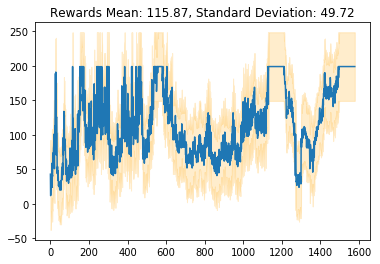

In [134]:
rewards = np.array(running_rewards)
rewards_mean = np.mean(rewards)
rewards_std = np.std(rewards)


plt.plot(running_rewards)
plt.fill_between(
    range(len(rewards)),
    rewards-rewards_std, 
    rewards+rewards_std, 
    color='orange', 
    alpha=0.2
)
plt.title(
    'Rewards Mean: {:.2f}, Standard Deviation: {:.2f}'.format(
        np.mean(running_rewards),
        np.std(running_rewards)
    )
)
plt.show()

We eventually converge but look at the variance. **Phew, how can we decrease the convergence time?**

_Inspiration for Implementation_: Soumith Chintala & Pytorch Developers